In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

All code below is basically implementations of the distribution and the log likelihood that is needed to be maximized.

In [3]:
def E(data,w, theta):
    #d: NrofSpins
    #w.shape: (d,d)
    #theta.shape: (d,)
    #data: (N,d)
    d = w.shape[0]
    correlations = np.sum(np.multiply((data@((1-np.eye(d))*w)), data), axis = 1)/2
    local_field = data@theta

    return -(correlations + local_field)

def E_indep(data, w, theta):
    #d: NrofSpins
    #w.shape: (d,d)
    #theta.shape: (d,)
    #data: (N,d)
    local_field = data@theta

    return -local_field

def p_star(data,w,theta, Energy_functional = E):
    return np.exp(-Energy_functional(data,w,theta))

def p(data,w,theta,Z, Energy_functional = E):
    return 1/Z * p_star(data,w,theta, Energy_functional)

def partition(w, theta, all_states, Energy_functional = E):
    return np.sum(p_star(all_states, w , theta, Energy_functional))

def log_likelihood(w, theta, data, Z, Energy_functional = E):
    return 1/len(data) * np.sum(np.log(p(data,w,theta, Z, Energy_functional)))

Implementation of both the free and clamped statistics. Note the usage of the einsum, which significantly sped up the computation and lessened the memory usage

In [73]:
def clamped_statistics(data):
    single = np.mean(data, axis = 0)
    double = np.einsum('ki,kj-> ij', data, data)/(len(data))

    return single, double

def free_statistics(w, theta, all_states, Z, Energy_functional = E):
    all_probs = p(all_states, w, theta, Z, Energy_functional)
    single = np.einsum('ki, k -> i', all_states, all_probs)
    double = np.einsum('ki, kj, k -> ij', all_states, all_states, all_probs)
    return single, double


Creation of the data toy model

In [5]:
lr = 1e-3
threshold = 1e-13
N = 1000
S = 10

# generate the data for the toy model
np.random.seed(42)
data_toy = np.array([np.random.randint(0, 2, size = S) for _ in range(N)])
for point in data_toy:
    point[point ==0] = -1
all_states = list(product([-1,1], repeat = S))
all_states = np.array([np.array(s) for s in all_states])

The function that is always used for the BM. Thus including the two approximations

In [120]:
def BM(data, lr , threshold, momentum = 0, random = False, print_iter = 500, Energy_functional = E, seed = None, MH_stats = False, MH_threshold = 5e-2, n_samples = 100, MF_LR_stats = False, m_threshold = 1e-10, correlation = True):
    #compute the clamped statistics
    if seed:
        np.random.seed(seed)
    clamped_single, clamped_double = clamped_statistics(data)
    S = data.shape[1]
    #initialize w and theta (random/zeros)
    if random:
        w = np.random.randn(S,S)
        w = np.tril(w) + np.tril(w, -1).T
        np.fill_diagonal(w,0.) 
        theta = np.random.randn(S)
    else:
        w = np.zeros((S,S))
        theta = np.zeros(S)

    error = np.inf
    gradient_old_single = np.zeros(theta.shape[0])
    gradient_old_double = np.zeros(w.shape[0])

    i=0
    if MH_stats:
        pattern = np.random.randint(0, 2, size = S)
        pattern[pattern == 0] = -1
        grad_single_list = []
        grad_double_list = []
    if S <= 10:
        Z = partition(w,theta, all_states, Energy_functional)   
        likelihoods = [log_likelihood(w,theta,data, Z, Energy_functional)]
    else:
        likelihoods = [big_log_likihood(w, theta, data)]
    while error > threshold:
        i += 1      
        #compute the free statistics
        if MH_stats:
            free_single, free_double, pattern = MH_sampler(w, theta, pattern, n_samples, correlation)
        elif MF_LR_stats:
            free_single, free_double = MF_LR_Sampler(w, theta, m_threshold)
        else:
            free_single, free_double = free_statistics(w,theta,all_states, Z, Energy_functional)
        if S > 10:
            if MH_stats:
                #have to always calculate m always for Z
                m = np.random.randn(len(theta))
                m = np.clip(m, -1, 1)
                m_error = np.inf
                while m_error > m_threshold: 
                    m_new = np.tanh(np.dot(w,m) + theta)        
                    m_error = np.max(np.abs(m_new - m))
                    m = m_new
            else:
                m = free_single         
        #calculating the new gradients
        gradient_single = clamped_single - free_single
        #setting the diagonal zero
        gradient_double = (1-np.eye(w.shape[0]))*(clamped_double - free_double)

        if np.allclose(gradient_double, gradient_old_double, rtol = 0, atol = 0):
            print("ref mistake")
            break

        #updating w and theta
        theta_new = theta + lr * gradient_single + momentum * gradient_old_single
        w_new = w + lr * gradient_double + momentum * gradient_old_double

        #determine error
        error_theta = np.mean(np.abs(theta_new - theta)) 
        error_w = np.mean(np.abs(w_new - w))
        if Energy_functional is E_indep:
            error_w = 0
        error = max(error_theta, error_w)

        theta = theta_new
        w = w_new

        if MH_stats:
            grad_single_list.append(np.mean(gradient_single))
            grad_double_list.append(np.mean(gradient_double))
            last_50_single = grad_single_list[-50:]
            last_50_double = grad_double_list[-50:]
            sum_single = np.abs(np.sum(last_50_single))
            sum_double = np.abs(np.sum(last_50_double))
            if sum_single < threshold * 1/lr and sum_double < threshold * 1/lr:
                print("single: ", sum_single)
                print("double: ", sum_double)
                break
            elif i % print_iter == 0:
                print("single: ", sum_single)
                print("double: ", sum_double)            
        
        gradient_old_single =  gradient_single
        gradient_old_double =  gradient_double

        if S <= 10 or (MH_stats == False and MF_LR_stats == False):
            Z = partition(w,theta, all_states, Energy_functional)
            likelihoods.append(log_likelihood(w,theta,data,Z, Energy_functional))
        else:
            likelihoods.append(big_log_likihood(w, theta, data, m))

        if i % print_iter == 0:
            print(i)
            print(error)
            if Energy_functional is E_indep:
                print(error_theta)
                print(free_single)
    # print(np.abs(clamped_double - free_double))
    return w, theta, likelihoods

In [10]:
w_exact_toy, theta_exact_toy, likelihoods_exact_toy = BM(data_toy, lr, threshold, momentum = 0.01)

500
1.9809741282852328e-06
1000
3.2574456551575247e-08
1500
5.884754084159102e-10
2000
1.0772966568296793e-11
2500
1.9792410332203357e-13


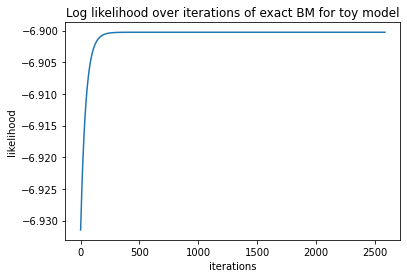

In [11]:
plt.plot([x for x in range(len(likelihoods_exact_toy))], likelihoods_exact_toy)
plt.xlabel("iterations")
plt.ylabel("likelihood")
plt.title("Log likelihood over iterations of exact BM for toy model")
plt.show()

Note that the above plot already starts quite high, most likely due to the fact that we opted to start with a weight matrix and bias vector that are zero. Since we can assume that for the toy model the spins do not have a true underlying correlation between them.

## Salamander data

In [7]:
salamander = np.loadtxt('bint.txt')
for point in salamander:
    point[point == 0] = -1

In [8]:
train_salamander = salamander[:,:953]
part_indices = np.random.choice(range(160), size = 10, replace = False)
train_salamander_part = train_salamander[part_indices]
train_salamander_part = train_salamander_part.transpose()

In [82]:
threshold_salamander = 1e-5
lr_salamander = 1e-3
mom_salamander = 0.01

w_exact_sal, theta_exact_sal, likelihoods_exact_sal = BM(train_salamander_part, lr_salamander, threshold_salamander, momentum = mom_salamander, random = False, seed = 42)

500
9.233032825487487e-05
1000
5.374050013283449e-05
1500
4.0394963322418206e-05
2000
3.325139358478779e-05
2500
2.8651963334455633e-05
3000
2.5378489937225023e-05
3500
2.2913232515375805e-05
4000
2.098577981439753e-05
4500
1.9434995198738814e-05
5000
1.826890062411046e-05
5500
1.7468042707929898e-05
6000
1.6769470354510706e-05
6500
1.6151869930300378e-05
7000
1.5600469271428997e-05
7500
1.5104517005357088e-05
8000
1.465580804410893e-05
8500
1.4247821635796076e-05
9000
1.387521243904899e-05
9500
1.3533502350221438e-05
10000
1.3218885841562167e-05
10500
1.2928099837278273e-05
11000
1.2658331041864868e-05
11500
1.2407145859746893e-05
12000
1.2172434740395643e-05
12500
1.1952366400064252e-05
13000
1.174534930182547e-05
13500
1.1549998806062445e-05
14000
1.1365108952893222e-05
14500
1.1189628140043095e-05
15000
1.1022638131319428e-05
15500
1.0863335937738582e-05
16000
1.0711018183540144e-05
16500
1.0565067625117885e-05
17000
1.0424941531958498e-05
17500
1.0290161677942167e-05
18000
1.01603

In [84]:
from collections import Counter

Z_dep = partition(w_exact_sal, theta_exact_sal, all_states)

#observed rate deter
full_data = salamander[part_indices]
full_data = full_data.transpose()

full_data = full_data.tolist()
new_data = map(tuple, full_data)
new_data_set = [list(item) for item in set(tuple(row) for row in full_data)]

observed_occ = Counter(new_data)

observed_rate = []
for i in new_data_set:
    observed_rate.append(observed_occ[tuple(i)]/len(full_data))

approximated_rate = p(new_data_set, w_exact_sal, theta_exact_sal, Z_dep)

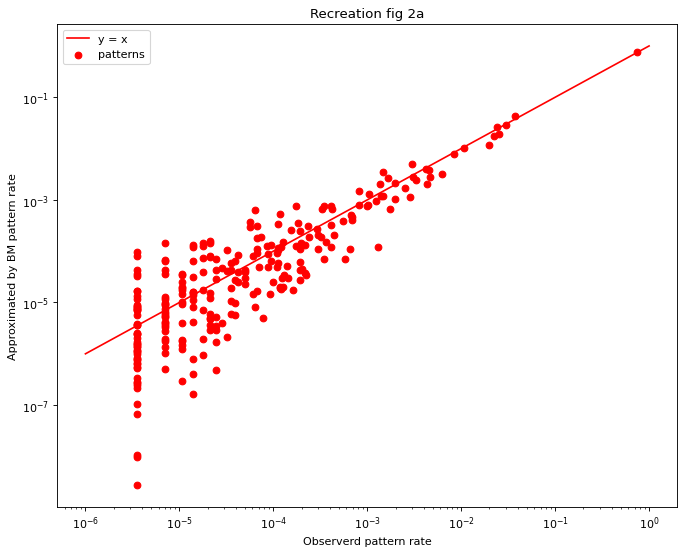

In [85]:
plt.figure(figsize = (10,8), dpi = 80, facecolor=(1, 1, 1))
plt.scatter(observed_rate, approximated_rate, label = "patterns", color = "red")      
plt.plot([x for x in np.linspace(0.000001,1, 10000)],[x for x in np.linspace(0.000001,1, 10000)], color = "red", label = "y = x")
plt.xlabel("Observerd pattern rate")
plt.ylabel("Approximated by BM pattern rate")
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.title("Recreation fig 2a")
plt.savefig(".\PLOTS\Exact_Salamander_Only_dep.png")
plt.show()

#### Creating the indep model

In [23]:
w_indep, theta_indep, liks_indep = BM(train_salamander_part, lr_salamander * 10 **(1), threshold_salamander * 10**(2), mom_salamander, Energy_functional= E_indep)

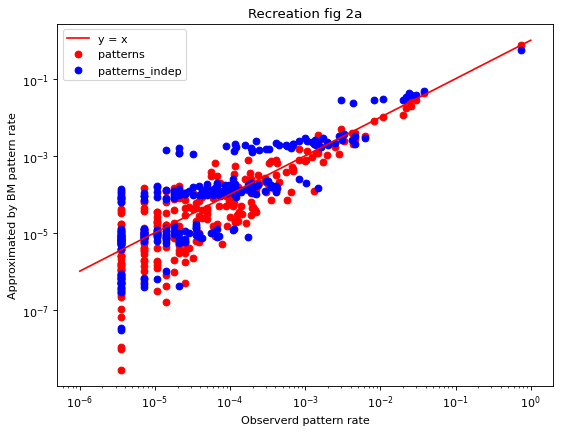

In [26]:
Z_indep = partition(w_indep, theta_indep, all_states, Energy_functional= E_indep)

approximated_rate_indep = p(new_data_set, w_indep, theta_indep, Z_indep, Energy_functional= E_indep)

plt.figure(figsize = (8,6), dpi = 80, facecolor=(1, 1, 1))
plt.scatter(observed_rate, approximated_rate, label = "patterns", color = "red")    
plt.scatter(observed_rate, approximated_rate_indep, label = "patterns_indep", color = "blue") 
plt.plot([x for x in np.linspace(0.000001,1, 10000)],[x for x in np.linspace(0.000001,1, 10000)], color = "red", label = "y = x")
plt.xlabel("Observerd pattern rate")
plt.ylabel("Approximated by BM pattern rate")
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.title("Recreation fig 2a")
plt.savefig(".\PLOTS\Exact_Salamander_with_indep")
plt.show()


## Metropolis Hastings Sampling

In [9]:
def E_difference(pattern, site, w, theta):
    return 2*pattern[site] * np.dot(w[site], pattern) + 2 * pattern[site] * theta[site]
    

In [110]:
def MH_sampler(w, theta, pattern, n_samples, correlation = True):    
    
    d = w.shape[0]
    
    # store the samples somewhere
    samples = np.zeros((n_samples, d))
    
    # get initial energy 
    energy = E(np.array([pattern]),w, theta)[0]
    
    # Precompute random numbers
    random_values = np.random.rand((n_samples + 1) * len(theta))
    random_flip_sites = np.random.randint(0, len(theta), size= (n_samples + 1)* len(theta))
    n_accept = 0
    for i in range(n_samples):
        if correlation:
            for j in range(len(theta)):
                diff = E_difference(pattern,random_flip_sites[i*j + j], w, theta)
                a = np.exp(-diff)
                if a > random_values[i*j + j]:
                    pattern[random_flip_sites[i*j + j]] *=-1
                    energy += diff
                    n_accept +=1
        else:
            diff = E_difference(pattern,random_flip_sites[i], w, theta)
            a = np.exp(-diff)
            if a > random_values[i]:
                pattern[random_flip_sites[i]] *=-1
                energy += diff
                n_accept +=1
        samples[i] = pattern    
    # samples[-1] = pattern
    # print(samples[-1])
    single = np.mean(samples, axis = 0)
    double = np.einsum('ki, kj -> ij', samples, samples)/len(samples)

    return single, double, pattern

In [50]:
def MH_gradient_comparer(data, n_samples, threshold, lr, momentum = 0.1, seed = None, random = False, correlation = True):
    if seed:
        np.random.seed(seed)
    clamped_single, clamped_double = clamped_statistics(data)
    S = data.shape[1]
    #initialize w and theta (random/zeros)
    if random:
        w = np.random.randn(S,S)
        w = np.tril(w) + np.tril(w, -1).T
        np.fill_diagonal(w,0.) 
        theta = np.random.randn(S)
    else:
        w = np.zeros((S,S))
        theta = np.zeros(S)
    error = np.inf
    gradient_old_single = np.zeros(theta.shape[0])
    gradient_old_double = np.zeros(w.shape[0])

    gradients_MH_single = []
    gradients_MH_double = []

    gradients_exact_single = []
    gradients_exact_double = []

    pattern = np.random.randint(0, 2, size = S)
    pattern[pattern == 0] = -1
    Z = partition(w,theta, all_states)
    likelihoods = [log_likelihood(w,theta,data, Z)]

    i = 0
    while error > threshold:
        i += 1
        free_single_MH, free_double_MH, pattern = MH_sampler(w,theta,pattern,n_samples, correlation)
        free_single_exact, free_double_exact = free_statistics(w,theta,all_states, Z)

        gradient_single_MH = clamped_single - free_single_MH
        gradient_single_exact = clamped_single - free_single_exact
        gradients_MH_single.append(gradient_single_MH)
        gradients_exact_single.append(gradient_single_exact)

        gradient_double_MH = clamped_double - free_double_MH
        gradient_double_exact = clamped_double - free_double_exact
        gradients_MH_double.append(gradient_double_MH)
        gradients_exact_double.append(gradient_double_exact)

        theta_new = theta + lr * gradient_single_exact + momentum * gradient_old_single
        w_new = w + lr * gradient_double_exact + momentum * gradient_old_double

        error_theta = np.mean(np.abs(theta_new - theta)) 
        error_w = np.mean(np.abs(w_new - w))
        error = max(error_theta, error_w)

        theta = theta_new
        w = w_new

        gradient_old_single =  gradient_single_exact
        gradient_old_double =  gradient_double_exact

        Z = partition(w, theta, all_states)
        likelihoods.append(log_likelihood(w,theta,data,Z))
        if i % 100 == 0:
            print(i)
            print(error)
        
    fig, axs = plt.subplots(1,2, figsize = (10,8), dpi = 80, facecolor=(1, 1, 1))

    if correlation:
        single_title = "Gradients for theta for " + str(n_samples) + " uncorrelated samples"
        double_title = "Gradients for w for " + str(n_samples) + " uncorrelated samples"
    else:
        single_title = "Gradients for theta for " + str(n_samples) + " correlated samples"
        double_title = "Gradients for w for " + str(n_samples) + " correlated samples"
    
    axs[0].plot([x for x in range(len(gradients_MH_single))], np.mean(np.array(gradients_MH_single), axis = 1), label = "MH")
    axs[0].plot([x for x in range(len(gradients_exact_single))], np.mean(np.array(gradients_exact_single), axis = 1), label = "exact")
    axs[0].set_title(single_title)
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel("Mean(Gradient)")
    axs[0].set_ylim([])
    axs[0].legend()


    axs[1].plot([x for x in range(len(gradients_MH_double))], np.mean(np.array(gradients_MH_double), axis = (1,2)), label = "MH")
    axs[1].plot([x for x in range(len(gradients_exact_double))], np.mean(np.array(gradients_exact_double), axis = (1,2)), label = "exact")
    axs[1].set_title(double_title)
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Mean(Gradient)")
    axs[1].legend()

    plt.show()

    return likelihoods, gradients_MH_single, gradients_MH_double, gradients_exact_single, gradients_exact_double

100
0.0025427434103105894
200
0.0014153976951205125
300
0.0010421903030291202
400
0.0006163832024146339
500
0.00030154685927312783
600
0.00012841144635462558
700
5.0671453914935434e-05
800
1.919759259477363e-05
900
7.24067272358005e-06
1000
2.8088304322927367e-06
1100
1.1330913018710735e-06
1200
4.754913019855097e-07
1300
2.0429847293095121e-07
1400
8.974000003909534e-08
1500
3.962380483861328e-08
1600
1.7518247471357342e-08


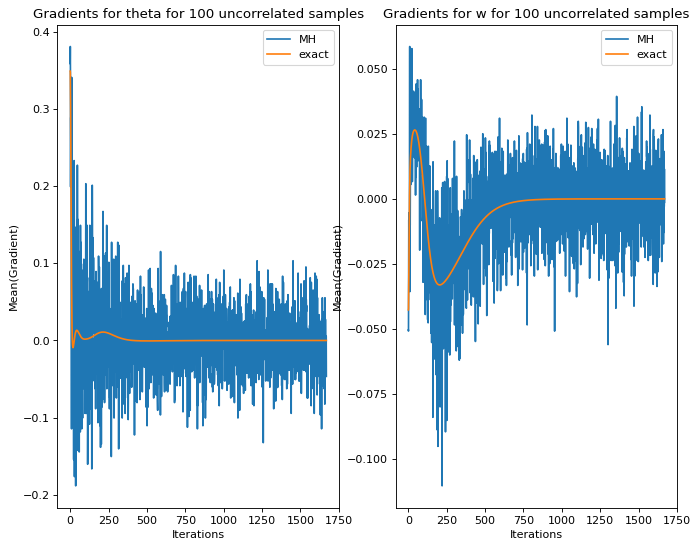

In [51]:
liks_comp, gradients_MH_single, gradients_MH_double, gradients_exact_single, gradients_exact_double = MH_gradient_comparer(data_toy, 100,1e-8,  1e-3, momentum= 0.01, seed = 42, random = True)

100
0.0025427434103105894
200
0.0014153976951205125
300
0.0010421903030291202
400
0.0006163832024146339
500
0.00030154685927312783
600
0.00012841144635462558
700
5.0671453914935434e-05
800
1.919759259477363e-05
900
7.24067272358005e-06
1000
2.8088304322927367e-06
1100
1.1330913018710735e-06
1200
4.754913019855097e-07
1300
2.0429847293095121e-07
1400
8.974000003909534e-08
1500
3.962380483861328e-08
1600
1.7518247471357342e-08


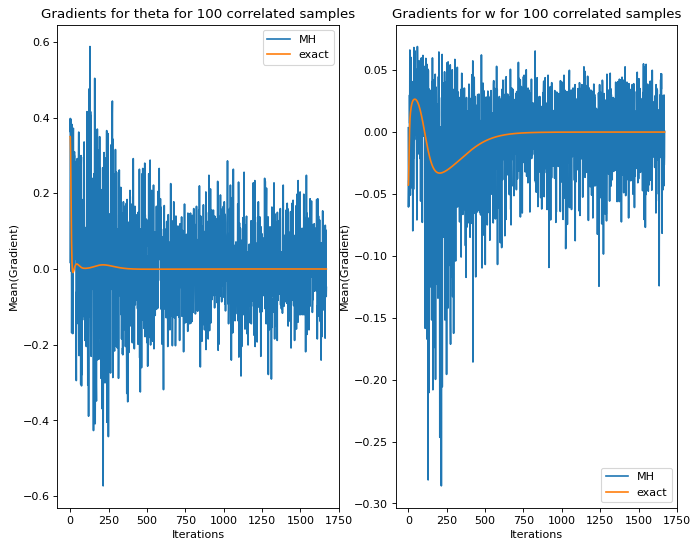

In [52]:
liks_comp_nocor, gradients_MH_single_nocor, gradients_MH_double_nocor, gradients_exact_single_nocor, gradients_exact_double_nocor = MH_gradient_comparer(data_toy, 100,1e-8,  1e-3, momentum= 0.01, seed = 42, random = True, correlation= False)

100
0.0025427434103105894
200
0.0014153976951205125
300
0.0010421903030291202
400
0.0006163832024146339
500
0.00030154685927312783
600
0.00012841144635462558
700
5.0671453914935434e-05
800
1.919759259477363e-05
900
7.24067272358005e-06
1000
2.8088304322927367e-06
1100
1.1330913018710735e-06
1200
4.754913019855097e-07
1300
2.0429847293095121e-07
1400
8.974000003909534e-08
1500
3.962380483861328e-08
1600
1.7518247471357342e-08


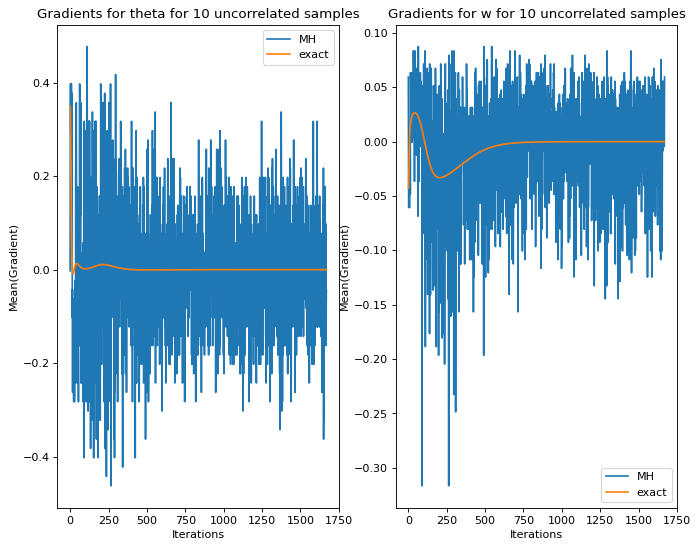

In [53]:
liks_comp_10, gradients_MH_single_10, gradients_MH_double_10, gradients_exact_single_10, gradients_exact_double_10 = MH_gradient_comparer(data_toy, 10,1e-8,  1e-3, momentum= 0.01, seed = 42, random = True)

100
0.0025427434103105894
200
0.0014153976951205125
300
0.0010421903030291202
400
0.0006163832024146339
500
0.00030154685927312783
600
0.00012841144635462558
700
5.0671453914935434e-05
800
1.919759259477363e-05
900
7.24067272358005e-06
1000
2.8088304322927367e-06
1100
1.1330913018710735e-06
1200
4.754913019855097e-07
1300
2.0429847293095121e-07
1400
8.974000003909534e-08
1500
3.962380483861328e-08
1600
1.7518247471357342e-08


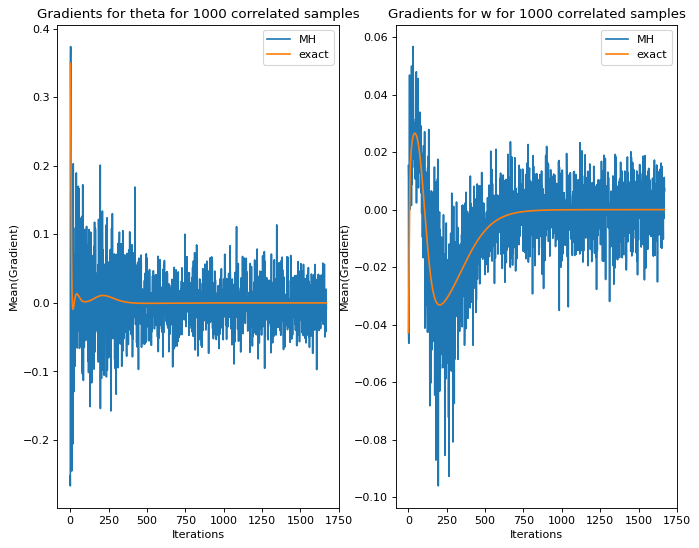

In [54]:
liks_comp_1000_nocor, gradients_MH_single_1000_nocor, gradients_MH_double_1000_nocor, gradients_exact_single_1000_nocor, gradients_exact_double_1000_nocor = MH_gradient_comparer(data_toy, 1000,1e-8,  1e-3, momentum= 0.01, seed = 42, random = True, correlation = False)

100
0.0025427434103105894
200
0.0014153976951205125
300
0.0010421903030291202
400
0.0006163832024146339
500
0.00030154685927312783
600
0.00012841144635462558
700
5.0671453914935434e-05
800
1.919759259477363e-05
900
7.24067272358005e-06
1000
2.8088304322927367e-06
1100
1.1330913018710735e-06
1200
4.754913019855097e-07
1300
2.0429847293095121e-07
1400
8.974000003909534e-08
1500
3.962380483861328e-08
1600
1.7518247471357342e-08


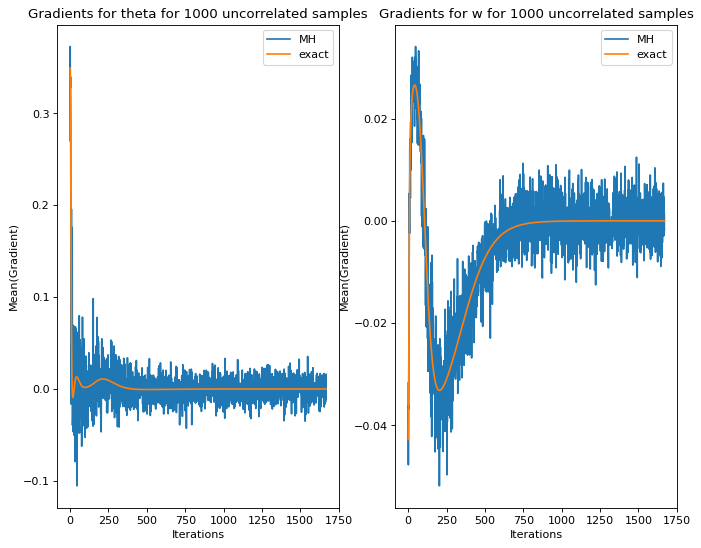

In [55]:
liks_comp_1000_nocor, gradients_MH_single_1000, gradients_MH_double_1000, gradients_exact_single_1000, gradients_exact_double_1000 = MH_gradient_comparer(data_toy, 1000,1e-8,  1e-3, momentum= 0.01, seed = 42, random = True)

100
0.0025427434103105894
200
0.0014153976951205125
300
0.0010421903030291202
400
0.0006163832024146339
500
0.00030154685927312783
600
0.00012841144635462558
700
5.0671453914935434e-05
800
1.919759259477363e-05
900
7.24067272358005e-06
1000
2.8088304322927367e-06
1100
1.1330913018710735e-06
1200
4.754913019855097e-07
1300
2.0429847293095121e-07
1400
8.974000003909534e-08
1500
3.962380483861328e-08
1600
1.7518247471357342e-08


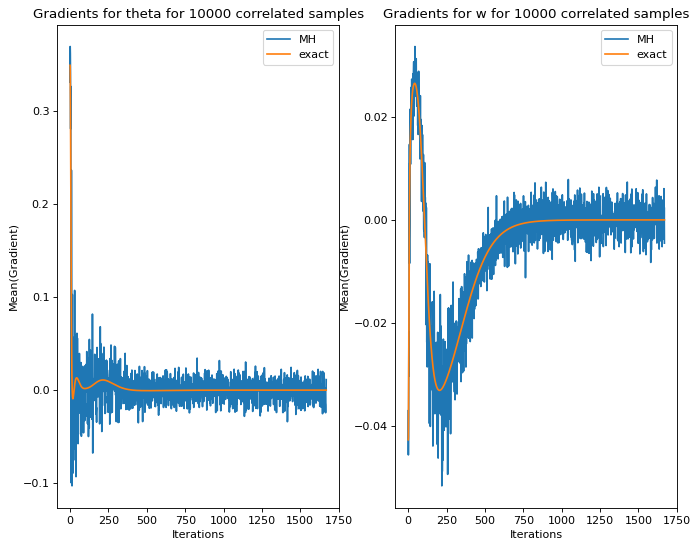

In [57]:
liks_comp_10000_nocor, gradients_MH_single_10000_nocor, gradients_MH_double_10000_nocor, gradients_exact_single_10000_nocor, gradients_exact_double_10000_nocor = MH_gradient_comparer(data_toy, 10000,1e-8,  1e-3, momentum= 0.01, seed = 42, random = True, correlation= False)

100
0.0025427434103105894
200
0.0014153976951205125
300
0.0010421903030291202
400
0.0006163832024146339
500
0.00030154685927312783
600
0.00012841144635462558
700
5.0671453914935434e-05
800
1.919759259477363e-05
900
7.24067272358005e-06
1000
2.8088304322927367e-06
1100
1.1330913018710735e-06
1200
4.754913019855097e-07
1300
2.0429847293095121e-07
1400
8.974000003909534e-08
1500
3.962380483861328e-08
1600
1.7518247471357342e-08


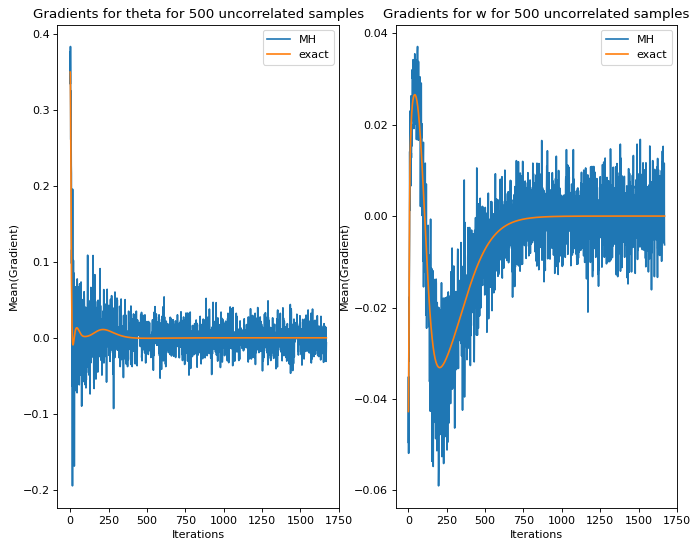

In [59]:
liks_comp_500, gradients_MH_single_500, gradients_MH_double_500, gradients_exact_single_500, gradients_exact_double_500 = MH_gradient_comparer(data_toy, 500,1e-8,  1e-3, momentum= 0.01, seed = 42, random = True)

100
0.0025427434103105894
200
0.0014153976951205125
300
0.0010421903030291202
400
0.0006163832024146339
500
0.00030154685927312783
600
0.00012841144635462558
700
5.0671453914935434e-05
800
1.919759259477363e-05
900
7.24067272358005e-06
1000
2.8088304322927367e-06
1100
1.1330913018710735e-06
1200
4.754913019855097e-07
1300
2.0429847293095121e-07
1400
8.974000003909534e-08
1500
3.962380483861328e-08
1600
1.7518247471357342e-08


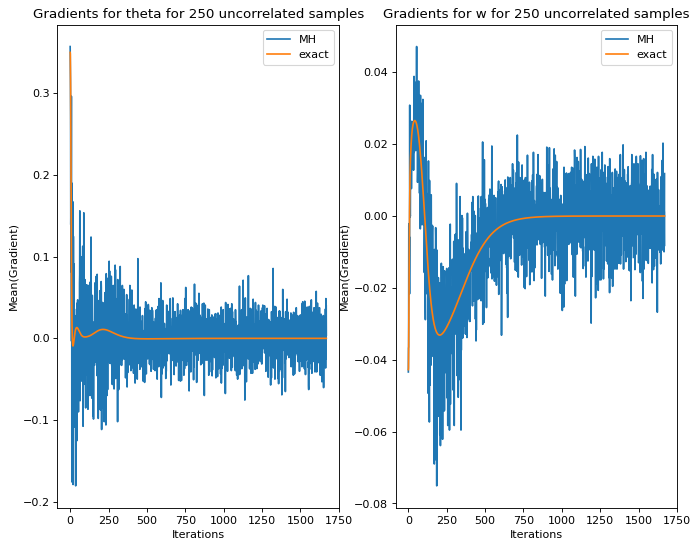

In [60]:
liks_comp_250, gradients_MH_single_250, gradients_MH_double_250, gradients_exact_single_250, gradients_exact_double_250 = MH_gradient_comparer(data_toy, 250,1e-8,  1e-3, momentum= 0.01, seed = 42, random = True)

In [130]:
# w_mh, theta_mh, liks_mh  = BM(data_toy, 1e-3, threshold, random = True, momentum= 0.01, seed = 42,  MH_stats= True, n_samples= 1000, print_iter= 1)

1
0.000802
2
0.00899519999999996
3
0.010549600000000027
4
0.008923599999999999
5
0.010377999999999995
6
0.009870199999999999
7
0.008885799999999994
8
0.004407600000000003
9
0.004292760000000006
10
0.008372400000000002
11
0.008084
12
0.0050107999999999715
13
0.004129800000000009
14
0.005572400000000024
15
0.007105199999999964
16
0.007474399999999981
17
0.003798360000000007
18
0.003750759999999998
19
0.003583200000000035
20
0.004089000000000005
21
0.005073199999999984
22
0.003426799999999998
23
0.004014320000000005
24
0.004852999999999991
25
0.0037681999999999967
26
0.0035024399999999977
27
0.003849599999999985
28
0.004802599999999979
29
0.004043
30
0.004044600000000006
31
0.00367100000000002
32
0.004331400000000011
33
0.004077800000000029
34
0.003098160000000005
35
0.004030400000000003
36
0.0039936000000000095
37
0.005128000000000013
38
0.003423400000000039
39
0.003274600000000015
40
0.0038718000000000025
41
0.004544400000000023
42
0.003971800000000008
43
0.0039050000000000035
44
0.0033

KeyboardInterrupt: 

In [77]:
w_mh_sal, theta_mh_sal, liks_mh_sal  = BM(train_salamander_part, 1e-3, 1e-5, momentum= 0, random = False, seed = 2,  MH_stats= True, n_samples= 250, print_iter= 100)

single:  39.5050870933893
double:  33.85198757607556
100
0.0007133817418677856
single:  20.018687093389293
double:  17.054227576075554
200
0.0002621817418677827
single:  8.782687093389299
double:  6.442547576075551
300
5.5827576075550556e-05
single:  5.815487093389297
double:  5.320467576075551
400
0.00010913410283315883
single:  3.2658870933892983
double:  2.7907075760755506
500
0.0001833082896117527
single:  4.4266870933892974
double:  1.989587576075551
600
8.371777544595838e-05
single:  0.6066870933892977
double:  0.39198757607555096
700
8.517103882476452e-05
single:  0.9786870933892979
double:  0.8228675760755507
800
8.974237145855213e-05
single:  4.649087093389299
double:  1.2087875760755509
900
6.804449108079592e-05
single:  1.5922870933892976
double:  0.368652423924449
1000
8.761301154249723e-05
single:  3.8314870933892973
double:  0.43950757607555113
1100
5.940264428121761e-05
single:  3.1626870933892977
double:  0.5483075760755509
1200
9.236919202518235e-05
single:  0.64611290

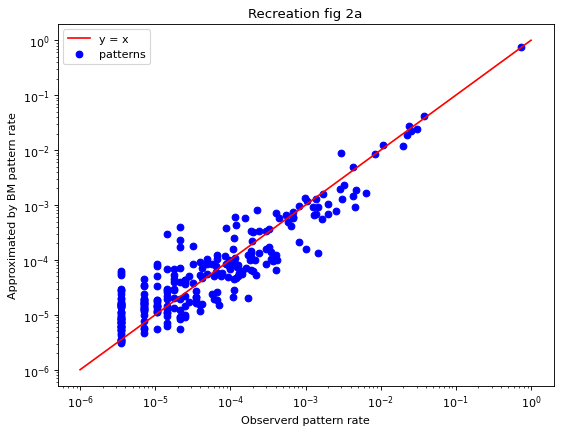

In [86]:
Z_mh = partition(w_mh_sal, theta_mh_sal, all_states)

approximated_rate_mh = p(new_data_set, w_mh_sal, theta_mh_sal, Z_mh)

plt.figure(figsize = (8,6), dpi = 80, facecolor=(1, 1, 1))
# plt.scatter(observed_rate, approximated_rate, label = "patterns", color = "red")    
plt.scatter(observed_rate, approximated_rate_mh, label = "patterns", color = "blue") 
plt.plot([x for x in np.linspace(0.000001,1, 10000)],[x for x in np.linspace(0.000001,1, 10000)], color = "red", label = "y = x")
plt.xlabel("Observerd pattern rate")
plt.ylabel("Approximated by BM pattern rate")
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.title("Recreation fig 2a")
plt.savefig(".\PLOTS\Exact_Salamander_with_indep")
plt.show()

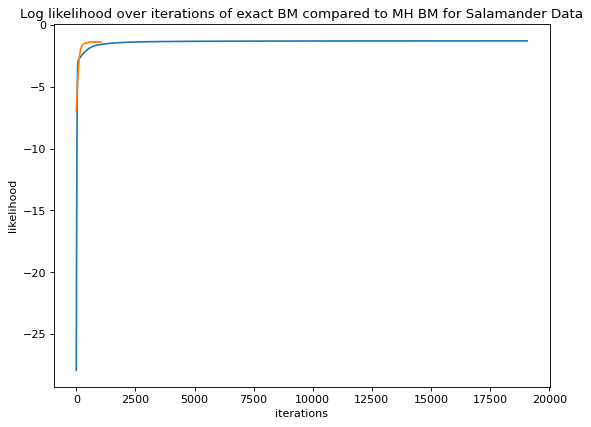

In [154]:
plt.figure(figsize = (8,6), dpi = 80, facecolor=(1, 1, 1))
plt.plot([x for x in range(len(likelihoods_exact_sal))], likelihoods_exact_sal)
plt.plot([x for x in range(len(liks_mh_sal))], liks_mh_sal)

plt.xlabel("iterations")
plt.ylabel("likelihood")
plt.title("Log likelihood over iterations of exact BM compared to MH BM for Salamander Data")
plt.show()

## MF and LR approximation

In [96]:
def MF_LR_Sampler(w,theta, m_threshold, m = None):
    # first needed to calculate the m's, through some fixed point iteration
    if m is None:
        m = np.random.randn(len(theta))
        m = np.clip(m, -1, 1)
        i = 0 
        error = np.inf
        while error > m_threshold: 
            i += 1
            m_new = np.tanh(np.dot(w,m) + theta)        
            error = np.max(np.abs(m_new - m))
            m = m_new
    single_free = np.copy(m)
    A = np.zeros_like(w)
    np.fill_diagonal(A, 1/(1-m**(2)))
    A = A - w
    
    ksi = np.linalg.inv(A)
    outer_m = np.outer(m,m)
    double_free = ksi + outer_m
    return single_free, double_free

In [88]:
w_mf, theta_mf,liks_mf = BM(train_salamander_part, 1e-3, 1e-5, momentum = 0, MF_LR_stats=True, m_threshold=1e-10, seed = 42)

500
5.309700447145682e-05
1000
1.4581986411488223e-05
1500
1.3242304350611079e-05
2000
0.001668686019322399


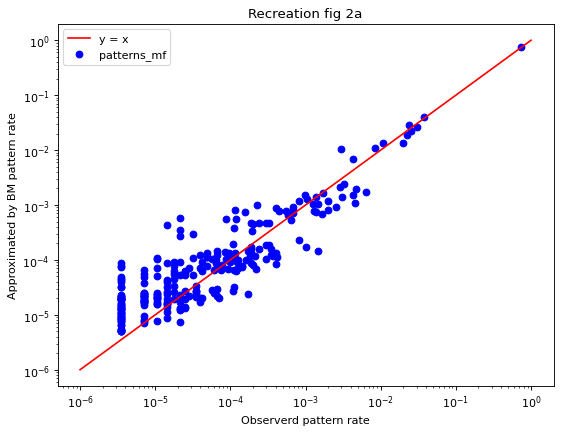

In [89]:
Z_mf = partition(w_mf, theta_mf, all_states)

approximated_rate_mf = p(new_data_set, w_mf, theta_mf, Z_mf)

plt.figure(figsize = (8,6), dpi = 80)
# plt.scatter(observed_rate, approximated_rate, label = "patterns", color = "red")    
plt.scatter(observed_rate, approximated_rate_mf, label = "patterns_mf", color = "blue") 
plt.plot([x for x in np.linspace(0.000001,1, 10000)],[x for x in np.linspace(0.000001,1, 10000)], color = "red", label = "y = x")
plt.xlabel("Observerd pattern rate")
plt.ylabel("Approximated by BM pattern rate")
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.title("Recreation fig 2a")
plt.show()

The likelihood plot for all 3 methods for the partial salamander data

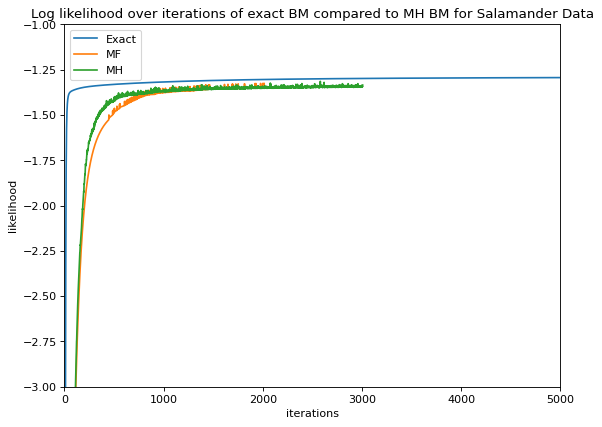

In [94]:
plt.figure(figsize = (8,6), dpi = 80, facecolor=(1, 1, 1))
plt.plot([x for x in range(len(likelihoods_exact_sal))], likelihoods_exact_sal, label = "Exact")
plt.plot([x for x in range(len(liks_mf))], liks_mf, label = "MF")
plt.plot([x for x in range(len(liks_mh_sal))], liks_mh_sal, label = "MH")
plt.legend()
plt.xlabel("iterations")
plt.xlim([0,5000])
plt.ylim([-3,-1])
plt.ylabel("likelihood")
plt.title("Log likelihood over iterations of exact BM compared to MH BM for Salamander Data")
plt.show()

## Full Salamander Data

Likelihood calculation that uses the Approximation for Z from the paper by Kappen and Rodriquez

In [107]:
def big_log_likihood(w, theta, data, m = None):
    #calculate Z according to paper Kappen 1997
    if m is None:
        m = np.random.randn(len(theta))
        m = np.clip(m, -1, 1)
        error = np.inf
        while error > 1e-10: 
            m_new = np.tanh(np.dot(w,m) + theta)        
            error = np.max(np.abs(m_new - m))
            m = m_new
    W_vector = np.dot(w,m)
    exponent = np.sum(np.log(2 * np.cosh(theta + W_vector))) - np.dot(W_vector, m) + 0.5 * np.dot(np.dot(m,w), m)
    Z = np.exp(exponent)
    return log_likelihood(w, theta, data, Z)


In [115]:
w_mf_160, theta_mf_160 ,liks_mf_160 = BM(train_salamander.transpose(), 1e-3, 1e-5, momentum = 0, MF_LR_stats=True, m_threshold=1e-10, seed = 42, print_iter = 5)

5
0.0009222107045569209
10
0.0015434718582754826
15
0.0017495724210444292
20
0.0017961536540417918
25
6.871215216840781e-05
30
5.1961225186786975e-05
35
4.148940104303867e-05
40
3.303710068093749e-05
45
2.85736850950272e-05
50
2.442909487295211e-05
55
2.1556018485668327e-05
60
1.971653944307962e-05
65
1.8175518923934074e-05
70
0.001849060882178862
75
0.0018494140494727228
80
1.5631459849173293e-05
85
0.0018502625351944362
90
1.4584028490493764e-05
95
1.4027841128071788e-05
100
1.3533255898926861e-05
105
0.0018480660179735805
110
0.0018483499438871852
115
1.3632327454187539e-05
120
1.2258736888274768e-05
125
1.2216633553118455e-05
130
1.1176999151735557e-05
135
0.0018457699630927801
140
1.1232074805147474e-05
145
1.035692897515306e-05
150
0.001844497328609729
155
1.0710062041113169e-05
160
1.1102837130531188e-05
165
1.2861384367384018e-05
170
1.1245104869814101e-05
175
1.1541143150171611e-05
180
1.0298933861267659e-05


In [121]:
w_mh_160, theta_mh_160 ,liks_mh_160 = BM(train_salamander.transpose(), 1e-3, 1e-5, momentum = 0, MH_stats= True, seed = 42, n_samples = 1000, print_iter= 50, correlation= False)

single:  9.968038431269674
double:  11.149468435860443
50
0.00017334046514296957
single:  0.24960093126967473
double:  0.7069607796104409
100
0.0001762933017444911
single:  0.18118656873032524
double:  0.08927031413955921
150
0.00017310584666841556
single:  0.0621240687303253
double:  0.13645484211044084
200
0.0001685055895855194
single:  0.00375093126967474
double:  0.2555464046104408
250
0.00015050000426285415
single:  0.18102406873032523
double:  0.08862265788955918
300
0.00018089030118704095
single:  0.07609906873032529
double:  0.10950921711044076
350
0.00018790393838536202
single:  0.15121156873032532
double:  0.036299064139559266
400
0.00011345688270592863
single:  0.06127406873032526
double:  0.13259546711044085
450
0.00016203344061516267
single:  0.2009490687303253
double:  0.12510547038955921
500
0.00020050455682712486
single:  0.08069906873032529
double:  0.09667234211044083
550
0.00016750026593651625
single:  0.14752406873032523
double:  0.02247047038955922
600
0.0001668523

In [133]:
w_mh_160_cor, theta_mh_160_cor ,liks_mh_160_cor = BM(train_salamander.transpose(), 1e-3, 1e-5, momentum = 0, MH_stats= True, seed = 42, n_samples = 7, print_iter= 50, correlation= True)

single:  9.414913431269675
double:  10.737236382289012
50
0.0002387436525633338
single:  0.20062771698396042
double:  0.6252720965747265
100
0.00018043794970769002
single:  0.005984859841103257
double:  0.25346406086044077
150
0.0001782864029006146
single:  0.06722942587318244
double:  0.12161138228901222
200
0.00019641079392145104
single:  0.1904437115874682
double:  0.1080537962824163
250
0.00020881387254534551
single:  0.09580085444461105
double:  0.07228102514615502
300
0.00014970024171788337
single:  0.0011579973017538554
double:  0.24779441800329785
350
0.0001488876761355119
single:  0.17080085444461096
double:  0.07008504628241644
400
0.00016310211643681607
single:  0.21365799730175386
double:  0.1550404034252736
450
0.00017252904362164597
single:  0.11187228301603956
double:  0.04279441800329795
500
0.00017237693936441312
single:  0.15955628841253186
double:  0.538374775146155
550
0.00020376309305201624
single:  0.42615799730175385
double:  0.5425627248538448
600
0.000159343169

In [135]:
w_mh_160_cor_250, theta_mh_160_cor_250 ,liks_mh_160_cor_250 = BM(train_salamander.transpose(), 1e-3, 1e-5, momentum = 0, MH_stats= True, seed = 42, n_samples = 250, print_iter= 50, correlation= True)

single:  82.21506343126967
double:  11.494543435860443
50
0.001840748268625393
single:  92.62706343126969
double:  1.0268496858604408
100
0.0018456482686253933
single:  92.77266343126968
double:  0.7619946858604407
150
0.0018640982686253971
single:  92.80801343126969
double:  0.6951528108604408
200
0.0018598482686253946
single:  92.82131343126967
double:  0.6699540608604408
250
0.0018648982686253924
single:  92.82891343126967
double:  0.6535865608604408
300
0.0018558482686253906
single:  92.81416343126968
double:  0.6791559358604408
350
0.0018578482686253978
single:  92.84011343126969
double:  0.6316615608604408
400
0.0018536982686253958
single:  92.82846343126967
double:  0.6507434358604408
450
0.0018548482686253879
single:  90.20856343126968
double:  0.4737934358604408
500
0.000125460847980063
single:  2.998586568730325
double:  5.471617189139558
550
8.815195501049318e-05
single:  1.766386568730325
double:  3.076137189139559
600
6.480231899265478e-05
single:  0.819136568730325
double

Below code was sometimes altered to generate the zoomed in version of the likelihood plot for the full salamander data

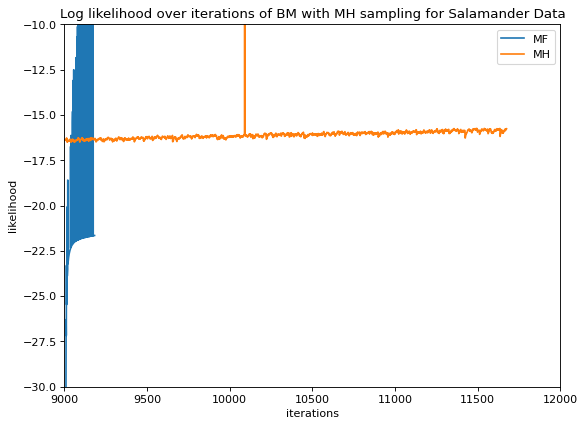

In [150]:
plt.figure(figsize = (8,6), dpi = 80, facecolor=(1, 1, 1))
plt.plot([x + 9000 for x in range(len(liks_mf_160))], liks_mf_160, label = "MF")
plt.plot([x for x in range(len(liks_mh_160_cor_250))], liks_mh_160_cor_250, label = "MH")
plt.legend()
plt.xlabel("iterations")
plt.xlim([9000,12000])
plt.ylim([-30,-10])
plt.ylabel("likelihood")
plt.title("Log likelihood over iterations of BM with MH sampling for Salamander Data")
plt.show()

## Directly solving the MF eqs


In [144]:
def direct_solve(data, eps, clamped_single, clamped_double):
    C = clamped_double - np.outer(clamped_single, clamped_single)
    C = C + np.eye(*C.shape)*eps
    m = clamped_single
    

    w = np.zeros_like(C)
    np.fill_diagonal(w, 1/(1-m**2))
    w = w - np.linalg.inv(C)
    np.fill_diagonal(w,0.)
    

    theta = np.arctanh(m) - np.dot(w, m)

    likelihood = big_log_likihood(w, theta, data, m)
    return w, theta, likelihood

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]


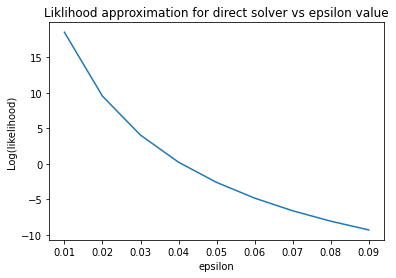

In [147]:
clamped_single, clamped_double = clamped_statistics(train_salamander.transpose())

epss = np.arange(1e-2, 1e-1, 1e-2)
print(epss)
y_ax = [direct_solve(train_salamander.transpose(), eps, clamped_single + 1e-8, clamped_double)[2] for eps in epss]
plt.plot(epss, y_ax)
plt.title("Liklihood approximation for direct solver vs epsilon value")
plt.xlabel("epsilon")
plt.ylabel("Log(likelihood)")
plt.show()
